## Implementation of Quantum Annealing Quasiparticle-NSM Hamiltonians using Ion-Q

In this notebook, we study and test the implementation of quantum adiabatic time evolution on several nuclei using the quasiparticle pairing approach on the Nuclear Shell Model Hamiltonians. First of all, we implement the target Hamiltonian.

#### Imports

In [1]:
import numpy as np
import json
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from src.qiskit_utils import get_hamiltonian

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector
import json
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, depolarizing_error, ReadoutError
from qiskit_aer import AerSimulator

#### Build up the TARGET Hamiltonian, we get the parameters for the DRIVER Hamiltonian and finally we build up the unitary step circuit function.

##### Load the $g_{AB}$ coefficients for the specific Hamiltonian. In this particular case we explore only $^{6}He$, therefore we do not need any 2-body quasiparticle coefficients.

In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

g_onebody={}

for a,key in enumerate(keys):
    i,j=key
    g_onebody[(i,j)]=values[a]

# print(t_onebody)
# t_onebody.pop((0,1))
# t_onebody.pop((0,2))
# t_onebody.pop((1,2))

print(g_onebody)


{(np.int64(0), np.int64(0)): np.float64(-8.4321), (np.int64(0), np.int64(1)): np.float64(1.0430999999999995), (np.int64(0), np.int64(2)): np.float64(-3.763858685577873), (np.int64(1), np.int64(0)): np.float64(1.0430999999999995), (np.int64(1), np.int64(1)): np.float64(-8.4321), (np.int64(1), np.int64(2)): np.float64(3.763858685577873), (np.int64(2), np.int64(0)): np.float64(-3.763858685577873), (np.int64(2), np.int64(1)): np.float64(3.763858685577873), (np.int64(2), np.int64(2)): np.float64(-5.1203)}


##### Here we get directly the driver Hamiltonian

In [3]:
coupling_term=-8.4321# this is the diagonal term of the H_T with the quasiparticle bitstring selected as in the paper
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]
# we need this dictionary to set the driver Hamiltonian in the unitary step of the QA algorithm
h_driver={0:coupling_term}
        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


print(hamiltonian_driver)

SparsePauliOp(['IIZ', 'III'],
              coeffs=[ 4.21605+0.j, -4.21605+0.j])


##### Then, we get the Target Hamiltonian using the function

In [4]:
hamiltonian_target=get_hamiltonian(g_onebody,n_qubits)

print(hamiltonian_target)

SparsePauliOp(['IXX', 'XIX', 'XXI', 'IYY', 'YIY', 'YYI', 'IIZ', 'IZI', 'ZII', 'III'],
              coeffs=[  0.52155   +0.j,  -1.88192934+0.j,   1.88192934+0.j,   0.52155   +0.j,
  -1.88192934+0.j,   1.88192934+0.j,   4.21605   +0.j,   4.21605   +0.j,
   2.56015   +0.j, -10.99225   +0.j])


##### Define a function that builds up the quantum circuit



In [166]:
class QACircuit():
    
    def __init__(self, n_qubits, g_onebody, h_driver, total_time, n_steps):
        self.n_qubits = n_qubits
        self.g_onebody = g_onebody
        self.h_driver = h_driver
        self.total_time = total_time
        self.n_steps = n_steps
        self.dt = total_time / n_steps
        self.circuit = QuantumCircuit(n_qubits)



    def initialize_state(self, initial_state):
        """Initialize the quantum circuit to a given initial state.

        Args:
            initial_state (list): List of qubit indices to be set to |1>.
        """
        for qubit in initial_state:
            self.circuit.x(qubit)
    
    def build_circuit(self,save_energy=False,hamiltonian_target=None,hamiltonian_driver=None):
        for i in range(self.n_steps):
            t = i * self.dt
            if save_energy:
                # Add measurement to save energy at each step
                if i==0:
                    self.energy=[]
                self.energy.append(self.expectation_value((1-t/self.total_time)*hamiltonian_driver+t/self.total_time*hamiltonian_target))
            self.circuit.compose(self.unitary_step(t), inplace=True)


    def expectation_value(self, hamiltonian):
        """Calculate the expectation value of a Hamiltonian with respect to the circuit state.

        Args:
            hamiltonian (SparsePauliOp): The Hamiltonian operator.

        Returns:
            float: The expectation value.
        """
        statevector = Statevector(self.circuit)
        exp_val = statevector.expectation_value(hamiltonian)
        return exp_val.real

    def unitary_step(self,t):
        """Create the unitary step for the QA algorithm.

        Args:
            t (float): time parameter.
            
        Returns:
            QuantumCircuit: The unitary step circuit.
        """
        qc=QuantumCircuit(self.n_qubits)
        

        
        # driver Hamiltonian terms in the 1st order Trotterization
        for key in h_driver.keys():
            i=key
            coeff=self.dt*self.h_driver[key]*self.driver_d[int(t/self.dt)]
            qc.rz(-0.5*coeff, i)
        
        
        # diagonal terms of the target Hamiltonian in the 1st order Trotterization
        for i in range(self.n_qubits):
            coeff=self.dt*self.g_onebody[(i,i)]*self.driver_t[int(t/self.dt )]
            qc.rz(-0.5*coeff, i)

        # off diagonal terms of the target Hamiltonian in the 1st order Trotterization
        for i in range(self.n_qubits):
            for j in range(i+1,self.n_qubits):
                coeff=self.dt*self.g_onebody[(i,j)]*self.driver_t[int(t/self.dt)]
                qc.rxx(0.5*coeff, i, j)
                qc.ryy(0.5*coeff, i, j)
            
        return qc
    
    def get_driver(self,driver_d=None,driver_t=None):
        
        time=np.linspace(0,self.total_time,self.n_steps)
        
        if driver_d is None:
            self.driver_d=1-time/self.total_time
        else:
            self.driver_d=driver_d
        
        if driver_t is None:
            self.driver_t=time/self.total_time
        else:
            self.driver_t=driver_t
    
    
    def circuit_measure_z(self):
        """Add measurement in the Z basis to the circuit."""
        circuit_z=self.circuit.copy()
        circuit_z.measure_all()

        return circuit_z
    
    def circuit_measure_x(self):
        """Add measurement in the X basis to the circuit."""
        circuit_x=self.circuit.copy()
        for qubit in range(self.n_qubits):
            circuit_x.h(qubit)
        circuit_x.measure_all()
        return circuit_x
    
    def circuit_measure_y(self):
        """Add measurement in the Y basis to the circuit."""
        circuit_y=self.circuit.copy()
        for qubit in range(self.n_qubits):
            circuit_y.sdg(qubit)
            circuit_y.h(qubit)
        circuit_y.measure_all()
        return circuit_y
        

Let's try the QA circuit class using the statevector simulator

In [200]:
QAHe6=QACircuit(n_qubits, g_onebody, h_driver, total_time=5, n_steps=50)

QAHe6.initialize_state([0])  # Initialize to |100> state

QAHe6.get_driver()

QAHe6.build_circuit(save_energy=True, hamiltonian_target=hamiltonian_target,hamiltonian_driver=hamiltonian_driver)
# only for small circuits
#QAHe6.circuit.draw('mpl')

print(QAHe6.expectation_value(hamiltonian_target))

-12.983805215135925


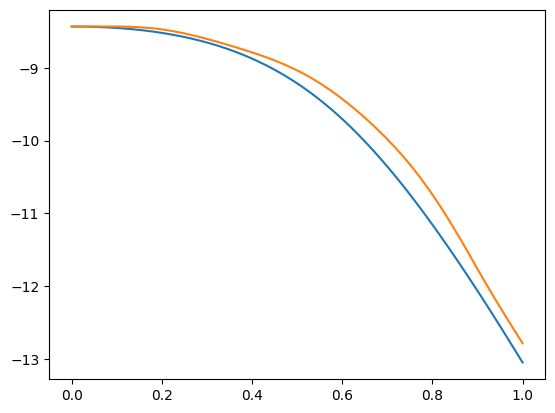

In [201]:
import matplotlib.pyplot as plt

data=np.load('data/6he_quasiparticle_qa.npz')
parameter=data['parameter']
energy=data['energy']

plt.plot(parameter,energy,label='QA classical simulation')
plt.plot(np.linspace(0,1,QAHe6.n_steps),np.asarray(QAHe6.energy),label='QA Quantum Circuit')

plt.show()

##### Let's transpile the quantum circuit using the Ion-Q backend

In [202]:
from qiskit_ionq import IonQProvider, GPI2Gate, MSGate

provider = IonQProvider()
backend_native = provider.get_backend("ionq_simulator", gateset="native")
print(QAHe6.circuit.count_ops)
ionq_circuit_transpiled=transpile(QAHe6.circuit, backend=backend_native,optimization_level=1)

print(ionq_circuit_transpiled.count_ops())

/home/ecosta/miniconda3/envs/qiskit-env/lib/python3.10/site-packages/qiskit_ionq/ionq_backend.py:127: IonQTranspileLevelWarning: Transpiler default optimization_level=2. IonQ (QIS) recommends 0-1 to avoid aggressive re-synthesis; use transpile(..., optimization_level=1).
  warn_bad_transpile_level()


<bound method QuantumCircuit.count_ops of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x77bbf391df60>>
OrderedDict([('gpi2', 5802), ('gpi', 1701), ('ms', 600)])


Cost of a $RXX + RYY$ gate in terms of primitive gates

In [203]:
c_rxx_ryy=QuantumCircuit(2)
c_rxx_ryy.rxx(0.3,0,1)
c_rxx_ryy.ryy(0.3,0,1)
print(c_rxx_ryy)
ionq_c_rxx_ryy_transpiled=transpile(c_rxx_ryy,optimization_level=3,basis_gates=['rzz','h','s'])
print(ionq_c_rxx_ryy_transpiled.count_ops())
print(ionq_c_rxx_ryy_transpiled)

c_rxx_ryy=QuantumCircuit(1)
c_rxx_ryy.rz(0.3,0)
c_rxx_ryy.draw('mpl')
ionq_c_rxx_ryy_transpiled=transpile(c_rxx_ryy, backend=backend_native,optimization_level=2)
print(ionq_c_rxx_ryy_transpiled.count_ops())
print(ionq_c_rxx_ryy_transpiled)


     ┌───────────┐┌───────────┐
q_0: ┤0          ├┤0          ├
     │  Rxx(0.3) ││  Ryy(0.3) │
q_1: ┤1          ├┤1          ├
     └───────────┘└───────────┘
OrderedDict([('h', 8), ('s', 8), ('rzz', 2)])
     ┌───┐          ┌───┐┌───┐┌───┐┌───┐┌───┐          ┌───┐┌───┐
q_0: ┤ H ├─■────────┤ H ├┤ S ├┤ S ├┤ S ├┤ H ├─■────────┤ H ├┤ S ├
     ├───┤ │ZZ(0.3) ├───┤├───┤├───┤├───┤├───┤ │ZZ(0.3) ├───┤├───┤
q_1: ┤ H ├─■────────┤ H ├┤ S ├┤ S ├┤ S ├┤ H ├─■────────┤ H ├┤ S ├
     └───┘          └───┘└───┘└───┘└───┘└───┘          └───┘└───┘
OrderedDict([('gpi2', 2), ('gpi', 1)])
global phase: 6.1332
         ┌───────────────┐┌────────────────┐┌───────────┐
q_0 -> 0 ┤ Gpi2(0.45225) ├┤ Gpi(-0.023873) ├┤ Gpi2(0.5) ├
         └───────────────┘└────────────────┘└───────────┘


So, consider that this gate takes $4$ non-local gates. The number of gates is $N_{qubit} \times (N_{qubit}-1) / 2$ therefore we have $4 \times 3=12$ per gate

#### Computation of the final energy

In [204]:
provider = IonQProvider(token="3LIAGvfKIPYBGrhES6VujeFSTI3uwDWI")

print(provider.backends()   )

[<qiskit_ionq.ionq_backend.IonQSimulatorBackend object at 0x77bbf3522e30>, <qiskit_ionq.ionq_backend.IonQQPUBackend object at 0x77bbf3521000>]


##### Get the noise model of Forte-1

In [205]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import depolarizing_error, thermal_relaxation_error, ReadoutError
from src.qiskit_utils import ionq_energy_expectation
# =========================
# Hardware parameters
# =========================

# Error rates
p_1q = 2.0e-4      # 0.020%
p_2q = 7.3e-3      # 0.730% because you count double the gates for the rxx ryy
p_ro = 3.8e-3     # 0.380% SPAM


# Coherence times (seconds)
T1 = 100.0
T2 = 1.0

# Gate times (seconds)
t_1q = 130e-6
t_2q = 970e-6
t_ro = 150e-6
t_reset = 50e-6

# =========================
# Create noise model
# =========================

noise_model = NoiseModel()

# =========================
# Depolarizing errors
# =========================

# 1-qubit depolarizing error (for gpi, gpi2)
depol_1q = depolarizing_error(p_1q, 1)

# 2-qubit depolarizing error (for ms)
depol_2q = depolarizing_error(p_2q, 2)

# Attach depolarizing noise
noise_model.add_all_qubit_quantum_error(depol_1q, ["rz","h","s"])
noise_model.add_all_qubit_quantum_error(depol_2q, ["rzz"])

# =========================
# Thermal relaxation errors
# =========================

# 1-qubit thermal relaxation
thermal_1q = thermal_relaxation_error(T1, T2, t_1q)

# 2-qubit thermal relaxation (tensor product of two 1Q channels)
thermal_2q = thermal_relaxation_error(T1, T2, t_2q).tensor(
    thermal_relaxation_error(T1, T2, t_2q)
)

# Attach thermal noise
noise_model.add_all_qubit_quantum_error(thermal_1q, ["rz","h","s"])
noise_model.add_all_qubit_quantum_error(thermal_2q, ["rzz"])

# =========================
# Readout (SPAM) error
# =========================

# # readout_error = ReadoutError([[1 - p_ro, p_ro],
# #                               [p_ro, 1 - p_ro]])

# # noise_model.add_all_qubit_readout_error(readout_error)



##### Get the energy for the transpiled circuit

In [206]:
from qiskit import transpile

shots=1000

circuit_z=QAHe6.circuit_measure_z()
circuit_x=QAHe6.circuit_measure_x()
circuit_y=QAHe6.circuit_measure_y()

basis_gates=['rzz','h','s','rz','x','y','z']

circuit_x_transpiled=transpile(circuit_x,basis_gates=basis_gates,optimization_level=3)
circuit_y_transpiled=transpile(circuit_y,basis_gates=basis_gates,optimization_level=3)
circuit_z_transpiled=transpile(circuit_z,basis_gates=basis_gates,optimization_level=3)

noisy_backend =  AerSimulator(noise_model=noise_model)

print(circuit_x.count_ops())
print(circuit_x_transpiled.count_ops())
energy_z,energy_xy,energy_xy_renormalized,p_sector=ionq_energy_expectation([circuit_x_transpiled,circuit_y_transpiled,circuit_z_transpiled],shots=shots,backend=noisy_backend,hamiltonian=hamiltonian_target,nparticle_sector=1)

print("Energy from IonQ noisy simulation:",energy_z,energy_xy,energy_xy_renormalized,p_sector,energy_xy_renormalized+energy_z)

OrderedDict([('rz', 200), ('rxx', 150), ('ryy', 150), ('h', 3), ('measure', 3), ('x', 1), ('barrier', 1)])
OrderedDict([('h', 1179), ('rz', 441), ('rzz', 294), ('s', 150), ('measure', 3), ('x', 1), ('barrier', 1)])
Energy from IonQ noisy simulation: -7.293915751789976 -0.4806003314702996 -1.1470174975424812 0.419 -8.440933249332458


Get the shots and compare them

In [207]:
from src.qiskit_utils import  obtain_frequencies_qiskit,get_shots_qiskit,compute_energy
results = get_shots_qiskit(circuit_x_transpiled,circuit_y_transpiled, circuit_z_transpiled, shots=shots,backend=noisy_backend)

Results for basis X: {'101': 153, '100': 102, '001': 105, '011': 127, '111': 101, '000': 129, '010': 176, '110': 107}
Results for basis Y: {'100': 101, '001': 114, '110': 111, '101': 170, '000': 119, '010': 157, '111': 111, '011': 117}
Results for basis Z: {'101': 105, '001': 124, '000': 142, '010': 143, '110': 109, '100': 151, '111': 105, '011': 121}


##### Try to do the Zero Noise Extrapolation

In [208]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RZZGate
import copy


def fold_rzz_circuits(circuit, repetitions):
    """
    Generate folded RZZ circuits for ZNE, mapping classical bits properly.

    Args:
        circuit (QuantumCircuit): Input circuit
        repetitions (list of odd integers >=1): fold factors
    
    Returns:
        list of QuantumCircuit
    """
    folded_circuits = []

    for n in repetitions:
        if n < 1 or n % 2 == 0:
            raise ValueError("Repetition factors must be odd integers >= 1")

        # Create a new circuit with same number of qubits and classical bits
        qc_folded = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)

        # Map old classical bits to new ones by index
        cbit_map = {old: qc_folded.clbits[i] for i, old in enumerate(circuit.clbits)}

        # Map old qubits by index
        qbit_map = {old: qc_folded.qubits[i] for i, old in enumerate(circuit.qubits)}

        # Copy instructions
        for instr, qargs, cargs in circuit.data:
            # Map qubits and classical bits
            new_qargs = [qbit_map[q] for q in qargs]
            new_cargs = [cbit_map[c] for c in cargs]

            if isinstance(instr, RZZGate):
                theta = instr.params[0]
                qc_folded.append(RZZGate(theta), new_qargs)
                for _ in range((n-1)//2):
                    qc_folded.append(RZZGate(theta), new_qargs)
                    qc_folded.append(RZZGate(-theta), new_qargs)
            else:
                qc_folded.append(instr, new_qargs, new_cargs)

        folded_circuits.append(qc_folded)

    return folded_circuits

In [209]:
full_circuit_transpiled=transpile(QAHe6.circuit,basis_gates=basis_gates,optimization_level=3)
repetitions=[1,3,5,7,9]
circuits_repeated=folded_circuits=fold_rzz_circuits(full_circuit_transpiled,repetitions)
for qc in circuits_repeated:
    print(qc.count_ops())


OrderedDict([('h', 1176), ('rz', 441), ('rzz', 294), ('s', 150), ('x', 1)])
OrderedDict([('h', 1176), ('rzz', 882), ('rz', 441), ('s', 150), ('x', 1)])
OrderedDict([('rzz', 1470), ('h', 1176), ('rz', 441), ('s', 150), ('x', 1)])
OrderedDict([('rzz', 2058), ('h', 1176), ('rz', 441), ('s', 150), ('x', 1)])
OrderedDict([('rzz', 2646), ('h', 1176), ('rz', 441), ('s', 150), ('x', 1)])


/tmp/ipykernel_28618/861685441.py:33: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


###### Compute the ZNE for each measurement direction

In [210]:
from src.qiskit_utils import  obtain_frequencies_qiskit,get_shots_qiskit,compute_energy
from src.qiskit_utils import ionq_energy_expectation


full_density_matrix_value=-7.328166666666667
n_iterations=50
repetitions=[1,3,5,7,9]

circuits=[circuit_x_transpiled,circuit_y_transpiled,circuit_z_transpiled]

folded_circuits_all=[]
for circuit in circuits:
    folded_circuits=fold_rzz_circuits(circuit,repetitions)
    folded_circuits_all.append(folded_circuits)

energy_results=[]
std_energy_results=[]
results_n=[]
for n in repetitions:
    circuits_n=[folded_circuits_all[i][(repetitions.index(n))] for i in range(len(circuits))]
    
    eng_ave=0.
    std_ave=0.
    energy_per_iteration=[]
    for i in range(n_iterations):
        energy_z,energy_xy,energy_xy_renormalized,p_sector=ionq_energy_expectation(circuits_n,shots=shots,backend=noisy_backend,hamiltonian=hamiltonian_target,nparticle_sector=1)
        energy_n_star=energy_z+energy_xy_renormalized
        energy_n=energy_z+energy_xy
        energy_per_iteration.append((energy_n+energy_n_star)/(1+p_sector))
    energy_results.append(np.average(energy_per_iteration))
    std_energy_results.append(np.std(energy_per_iteration))
    print(f"Energy for repetition {n}:",np.average(energy_per_iteration),'with p-sector:',p_sector,'')

/tmp/ipykernel_28618/861685441.py:33: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


Energy for repetition 1: -11.708773591981016 with p-sector: 0.392 
Energy for repetition 3: -10.74461337618384 with p-sector: 0.396 
Energy for repetition 5: -10.631459039265298 with p-sector: 0.39 
Energy for repetition 7: -10.705951700255556 with p-sector: 0.375 
Energy for repetition 9: -10.612385970201894 with p-sector: 0.392 


See the results

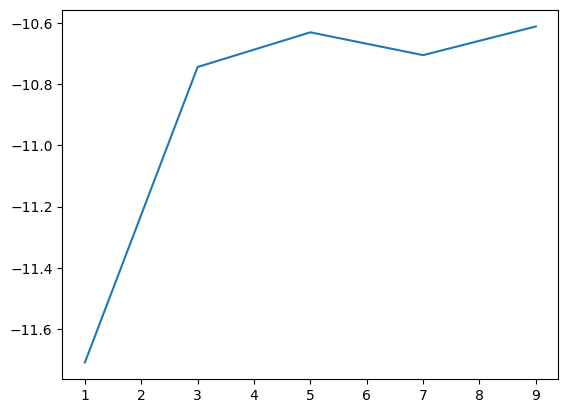

In [211]:
plt.plot(repetitions,energy_results)
plt.show()

import numpy as np
from scipy.optimize import curve_fit

def exponential_zne(repetitions, energies):
    """
    Exponential zero-noise extrapolation: E(R) = A * exp(-gamma * R)
    
    Args:
        repetitions (list or array): fold factors, e.g., [1,3,5]
        energies (list or array): measured energies corresponding to repetitions
    
    Returns:
        A: extrapolated zero-noise energy
        fit_params: dictionary with A and gamma
    """
    repetitions = np.array(repetitions, dtype=float)
    energies = np.array([float(e) for e in energies], dtype=float)
    
    # Exponential decay function
    def exp_func(R, A, gamma):
        return A * np.exp(-gamma * R)
    
    # Initial guess: A = energy at smallest R, gamma = 0.1
    p0 = [0.5, 0.1]
    
    # Fit curve
    params, _ = curve_fit(exp_func, repetitions, energies, p0=p0)
    
    A, gamma = params
    return A, {"A": A, "gamma": gamma}



In [212]:


de=(energy_results[-1]-np.asarray(energy_results))/energy_results[-1]
print(de,std_energy_results)

A, fit_params = exponential_zne(np.asarray(repetitions)*p_2q, de)
print("Extrapolated zero-noise energy:", (1-A)*energy_results[-1])
print("Fit parameters:", fit_params)

[-0.10331208 -0.01245972 -0.00179725 -0.00881665 -0.        ] [np.float64(0.3728721545597211), np.float64(0.33208744911025156), np.float64(0.35439511507104615), np.float64(0.36116923772937465), np.float64(0.3293348873124945)]
Extrapolated zero-noise energy: -13.712365649790723
Fit parameters: {'A': np.float64(-0.29210958669361825), 'gamma': np.float64(142.42851327691278)}


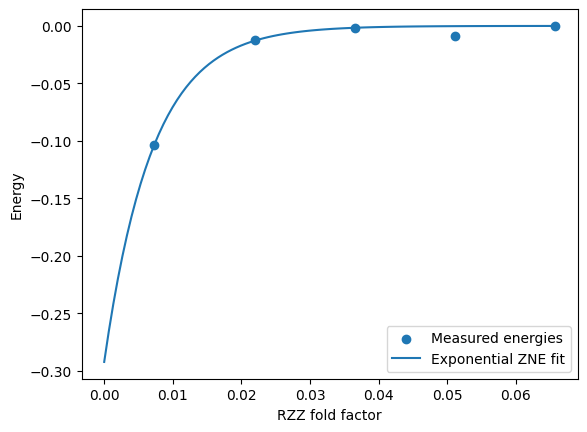

In [213]:
import matplotlib.pyplot as plt

x_fit = np.linspace(0, max(repetitions)*p_2q, 100)
y_fit = fit_params["A"] * np.exp(-fit_params["gamma"] * x_fit)

plt.scatter(np.asarray(repetitions)*p_2q, de, label="Measured energies")
plt.plot(x_fit, y_fit, label="Exponential ZNE fit")
plt.xlabel("RZZ fold factor")
plt.ylabel("Energy")
plt.legend()
plt.show()

##### Get the energy using the IonQ simulator

In [164]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit_ionq import IonQProvider
from src.qiskit_utils import  obtain_frequencies_qiskit,get_shots_qiskit,compute_energy
from src.qiskit_utils import ionq_energy_expectation

provider = IonQProvider(token="3LIAGvfKIPYBGrhES6VujeFSTI3uwDWI")
#noisy_backend = provider.get_backend("ionq_simulator",gateset="native")
noisy_backend = provider.get_backend("ionq_simulator")
noisy_backend.set_options(noise_model="forte-enterprise-1")
#noisy_backend=BasicSimulator()
shots=1000

# get the circuits for each basis measurement
circuit_z=QAHe6.circuit_measure_z()
ionq_circuit_transpiled_z=transpile(circuit_z, backend=noisy_backend,optimization_level=1)
print(ionq_circuit_transpiled_z.count_ops())

circuit_y=QAHe6.circuit_measure_y()
ionq_circuit_transpiled_y=transpile(circuit_y, backend=noisy_backend,optimization_level=1)

circuit_x=QAHe6.circuit_measure_x()
ionq_circuit_transpiled_x=transpile(circuit_x, backend=noisy_backend,optimization_level=1)

# Run the circuit on the IonQ simulator with forte-1 noise model
#results = get_shots_qiskit(ionq_circuit_transpiled_x, ionq_circuit_transpiled_y, ionq_circuit_transpiled_z, shots=shots,backend=noisy_backend)
energy_z,energy_xy,energy_xy_renormalized,p_sector=ionq_energy_expectation([ionq_circuit_transpiled_x,ionq_circuit_transpiled_y,ionq_circuit_transpiled_z],shots=shots,backend=noisy_backend,hamiltonian=hamiltonian_target,nparticle_sector=1)

print("Energy from IonQ noisy simulation:",energy_z,energy_xy,energy_xy_renormalized,p_sector,energy_xy_renormalized+energy_z)

/home/ecosta/miniconda3/envs/qiskit-env/lib/python3.10/site-packages/qiskit_ionq/ionq_backend.py:127: IonQTranspileLevelWarning: Transpiler default optimization_level=2. IonQ (QIS) recommends 0-1 to avoid aggressive re-synthesis; use transpile(..., optimization_level=1).
  warn_bad_transpile_level()


OrderedDict([('rxx', 90), ('ryy', 90), ('rz', 59), ('p', 29), ('measure', 3), ('ry', 1), ('barrier', 1)])


KeyboardInterrupt: 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit_ionq import IonQProvider
from src.qiskit_utils import  obtain_frequencies_qiskit,get_shots_qiskit,compute_energy
provider = IonQProvider(token="3LIAGvfKIPYBGrhES6VujeFSTI3uwDWI")
noisy_backend = provider.get_backend("ionq_simulator")
#noisy_backend.set_options(noise_model="forte-1",sampler_seed=42)
noisy_backend=BasicSimulator()
shots=100

# get the circuits for each basis measurement
circuit_z=QAHe6.circuit_measure_z()
ionq_circuit_transpiled_z=transpile(circuit_z, backend=noisy_backend,optimization_level=1)

circuit_y=QAHe6.circuit_measure_y()
ionq_circuit_transpiled_y=transpile(circuit_y, backend=noisy_backend,optimization_level=1)

circuit_x=QAHe6.circuit_measure_x()
ionq_circuit_transpiled_x=transpile(circuit_x, backend=noisy_backend,optimization_level=1)

# Run the circuit on the IonQ simulator with forte-1 noise model
results = get_shots_qiskit(ionq_circuit_transpiled_x, ionq_circuit_transpiled_y, ionq_circuit_transpiled_z, shots=shots,backend=noisy_backend)

Results for basis X: {'101': 31, '001': 3, '000': 7, '010': 29, '110': 11, '011': 10, '111': 4, '100': 5}
Results for basis Y: {'011': 12, '100': 14, '010': 33, '101': 25, '110': 4, '001': 5, '000': 6, '111': 1}
Results for basis Z: {'010': 48, '100': 29, '001': 23}


Obtain the frequencies and correct using the symmetry sector projection

In [33]:
frequencies = obtain_frequencies_qiskit(results, shots=shots)


normalized_freqs_z={}
p_sector=0.
for key in frequencies['Z'].keys():
    print(key,np.sum(key))
    if np.sum(key)==-1:
        p_sector+=frequencies['Z'][key]
        normalized_freqs_z[key]=frequencies['Z'][key]
    else:
        normalized_freqs_z[key]=0.
print(p_sector)
# we need to normalize it again
for key in normalized_freqs_z.keys():
    normalized_freqs_z[key]/=p_sector

# remove the normalization due to the post-selection
frequencies['Z']=normalized_freqs_z

print(frequencies['Z'])
print(n_qubits)

(np.float64(-1.0), np.float64(-1.0), np.float64(-1.0)) -3.0
(np.float64(-1.0), np.float64(-1.0), np.float64(1.0)) -1.0
(np.float64(-1.0), np.float64(1.0), np.float64(-1.0)) -1.0
(np.float64(-1.0), np.float64(1.0), np.float64(1.0)) 1.0
(np.float64(1.0), np.float64(-1.0), np.float64(-1.0)) -1.0
(np.float64(1.0), np.float64(-1.0), np.float64(1.0)) 1.0
(np.float64(1.0), np.float64(1.0), np.float64(-1.0)) 1.0
(np.float64(1.0), np.float64(1.0), np.float64(1.0)) 3.0
0.41000000000000003
{(np.float64(-1.0), np.float64(-1.0), np.float64(-1.0)): 0.0, (np.float64(-1.0), np.float64(-1.0), np.float64(1.0)): 0.2926829268292683, (np.float64(-1.0), np.float64(1.0), np.float64(-1.0)): 0.4146341463414634, (np.float64(-1.0), np.float64(1.0), np.float64(1.0)): 0.0, (np.float64(1.0), np.float64(-1.0), np.float64(-1.0)): 0.2926829268292683, (np.float64(1.0), np.float64(-1.0), np.float64(1.0)): 0.0, (np.float64(1.0), np.float64(1.0), np.float64(-1.0)): 0.0, (np.float64(1.0), np.float64(1.0), np.float64(1.0)):

In [34]:
def compute_energy(frequencies, t_onebody,renormalization_factor=None):
    energy_component_z = 0.
    energy_component_y = 0.
    energy_component_x = 0.

    for (i, j), value in t_onebody.items():
        if i != j:    
            freq = frequencies['Y']
            for key in freq.keys():
                energy_component_y += 0.25 * value * key[n_qubits-1-i] * key[n_qubits-1-j] * freq[key]
                

            freq = frequencies['X']
            for key in freq.keys():
                energy_component_x += 0.25 * value * key[n_qubits-1-i] * key[n_qubits-1-j] * freq[key]        

        
        elif i == j:
            # convert projector from Z+I to I-Z
            freq = frequencies['Z']
            for key in freq.keys():
                energy_component_z += 0.5 * value * (key[n_qubits-1-i] + 1) * freq[key]
    
    # we add this renormalization factor to perform an approximate restoration of the symmetry sector
    print(energy_component_x,energy_component_y,energy_component_z)
    if renormalization_factor is not None:
        print('bla bla')
        energy_component_y /=  renormalization_factor
        energy_component_x /=  renormalization_factor

    print(energy_component_x,energy_component_y,energy_component_z)

    return energy_component_x + energy_component_y + energy_component_z

In [35]:
energy = compute_energy(frequencies, g_onebody,renormalization_factor=p_sector)
print("Energy from IonQ simulator with forte-1 noise model:", energy)

0.36369469484622996 -0.5269402159809023 -7.462792682926829
bla bla
0.8870602313322681 -1.2852200389778106 -7.462792682926829
Energy from IonQ simulator with forte-1 noise model: -7.860952490572371
